## This Notebook - Goals - FOR EDINA 

**What?:** <br>
- Introduction/tutorial to <code>EarthPy</code>, a geospatial python library
- Illustate the main features of this library when visualizing elevation data

**Who?:** <br>
- Academics and students in geosciences and other STEM degrees
- Geophysical Data Science course
- USers interested in geospatial data analysis and elevation data
 
**Why?:** <br>
- Tutorial/guide to process and plot elevation data

**Noteable features to exploit:** <br>
- Use of pre-installed libraries

**How?:** <br>
- Effective use of core libraries in the Geospatial Notebook
- Step-by step processing of OS terrain 50 DTM data of the Lake District downloaded from DigiMap
- Clear visualizations - concise explanations
<hr>

# Plotting elevation data using EarthPy
<code>EarthPy</code> is a geospatial python library that makes it easier to plot and work with spatial raster and vector data using open source tools. <code>EarthPy</code> comes with the ability to download example datasets using the <code>earthpy.data.get_data()</code> function. This Notebook, however, uses OS terrain 50 DTM data of the Lake District, which was obtained from [Digimap](https://digimap.edina.ac.uk/os). <br>
This Notebook illustrates different ways of plotting the Lake District data using the <code>EarthPy</code> library. The main difference to other methods of visualizing the data is <code>EarthPy</code>'s <code>hillshade()</code> function. This enables the user to overlay raster data on top of a hillshade. A hillshade is a 3D representation of a surface and is generally rendered in greyscale. The darker and lighter colors represent the shadows and highlights that you would visually expect to see in a terrain model. Hillshades are often used as an underlay in a map to make the data appear more 3D and thus visually more interesting. 

**Notebook contents:**
- Importing the necessary libraries
- Creating custom colourmap to reflect typical terrain colours
- Customizing the colourbars of the maps
- <a href='#data'>Pre-processing the OS terrain 50 DTM data of the Lake District</a>
- <a href='#no'>Terrain map without hillshade using <code>EarthPy</code></a>
- <a href='#azi'>Hillshade maps of the Lake District with varying azimuthal angles</a>
- <a href='#alt'>Hillshade maps  of the Lake District with varying altitude angles</a>
- <a href='#hill'>Terrain map of the Lake District overlayed on top of a hillshade</a>

In [1]:
# General general libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Import libraries to preprocess the data
import zipfile, os
from osgeo import gdal, osr
import rasterio as rio

# Import earthpy modules
import earthpy.spatial as es
import earthpy.plot as ep

# Hide warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set up function to customize the chosen matplotlib colormap
def truncate_colormap(cmap, minval, maxval, n=100):
    cmapsample = cmap(np.linspace(minval, maxval, n)) #Sample the original colormap at n points between minval and maxval
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
           'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmapsample)  #Create new colormap using the range that was sampled in cmapsample
    return new_cmap #Return new colormap that can be called upon with get_cmap

# See: https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib

<a id='data'></a>
## Pre-processing the OS terrain 50 DTM data of the Lake District 
The data from Digimap can be downloaded in a zip file containing all the necessary files and documentation. The data contains Ordnance Survey data © Crown copyright and database right 2020. [[1]](#References) <br> 
Before it can be plotted, it first needs to be loaded into the Notebook and preprocessed. The unzipped folder reveals that the separate ascii files are split into folders named after the National Grid tiles they belong to. The files ending with ".asc" also need to be converted to ".tif" images and merged into one large ".tif" image to make plotting it easier.<br>
*Note: Geotiff files can be plotted with <code>EarthPy</code> straight away, so any users who are hoping to visualize a geotiff file and are using this Notebook as a template can skip this section.*

In [3]:
# ONLY RUN ONCE

## Extract the folders from the zip file into a directory "./data/LakeDistrict"
z = zipfile.ZipFile('./LakeDistrictData/Lake_District.zip')
z.extractall(path="./data/LakeDistrict")

In [4]:
# ONLY RUN ONCE

## Convert each ".asc" file into a geotiff files
drv = gdal.GetDriverByName('GTiff')
for item in os.listdir("./data/LakeDistrict/terrain-50-dtm_3563996"):
    for i in os.listdir("./data/LakeDistrict/terrain-50-dtm_3563996/" + item):
        if i.endswith(".asc"):
            ds_in = gdal.Open('./data/LakeDistrict/terrain-50-dtm_3563996/' + item + "/" + i )
            i = i.strip('.asc')
            ds_out = drv.CreateCopy(i +'.tif', ds_in)
            srs = osr.SpatialReference()
            srs.ImportFromEPSG(7405)
            ds_out.SetProjection(srs.ExportToWkt())
            ds_in = None
            ds_out = None

In [5]:
# ONLY RUN ONCE

## Combine all the individual geotiff files into one called "merged.tif"
!gdal_merge.py  -o merged.tif NY10.tif NY11.tif NY12.tif NY20.tif NY21.tif NY22.tif NY30.tif NY31.tif NY32.tif NY40.tif NY41.tif NY42.tif NY50.tif NY51.tif NY52.tif SD18.tif SD19.tif SD28.tif SD29.tif SD38.tif SD39.tif SD48.tif SD49.tif SD58.tif SD59.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [6]:
# Load in the data using rasterio
src = rio.open("merged.tif")
elevation = src.read(1)

<a id='no'></a>
## Using EarthPy without hillshade
The following cell uses the <code>earthpy.plot</code>  module of the library to plot the elevation data. This does not include the <code>hillshade()</code> function yet. The cbar argument of <code>earthpy.plot.plot_bands()</code> has been disabled as it does not add a colourbar label. Instead <code>matplotlib</code> was used to create a customized colourbar.

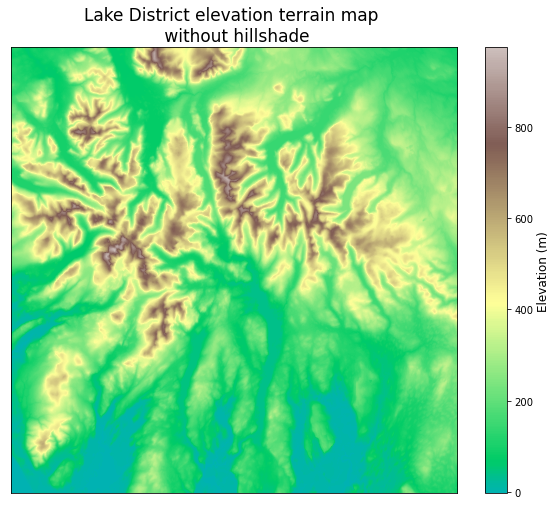

In [7]:
# Set figure size and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Specify the colormap segment for this example
cmap = plt.get_cmap('terrain')
new_cmap = truncate_colormap(cmap, 0.2, 0.9)

# Create terrainmap without hillshade using EarthPy
norm = matplotlib.colors.Normalize(vmin=elevation.min(), 
                                   vmax=elevation.max())
ep.plot_bands(elevation, cmap=new_cmap, ax=ax,
    cbar=False, norm=norm)

# Add colorbar and customize the map
sm = plt.cm.ScalarMappable(norm = norm, cmap=new_cmap)
plt.colorbar(sm, ax=ax, shrink=0.82).set_label(label = 'Elevation (m)', size=12)

ax.set_title("Lake District elevation terrain map \n without hillshade", size=17)
plt.show()

# Save the figure - uncomment code below
#plt.savefig("LDearthpywithouthillshade")

<a id='azi'></a>
## Hillshade function - changing the azimuth
The <code>hillshade()</code> function is part of the earthpy.spatial module and has 2 parameters, the azimuth and the altitude, which can be adjusted if wished. <br>
The azimuth argument within <code>hillshade()</code> sets the location of the Sun with respect to the map. Its values range from 0° to 360°. If it is set to be 0°, the Sun is directly to the North of the map, and moves in a clockwise direction as you increase the azimuthal angle. The default azimuth is 30°.


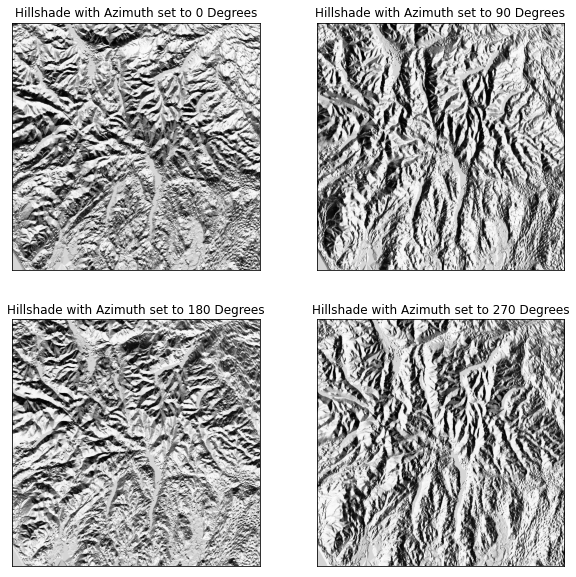

In [8]:
# Set figure size and axes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# Create hillshade maps with azimuthal angles of 0°, 90°, 180° and 270°
angle = [0, 90, 180, 270]
axes =[ax, ax2, ax3, ax4]
for i in range(0,4):
    # Change the azimuth of the hillshade layer
    hillshade_azimuth = es.hillshade(elevation, azimuth=angle[i])
    # Plot the hillshade layer with the modified azimuth
    ep.plot_bands(hillshade_azimuth, ax=axes[i], 
                  cbar=False, title="Hillshade with Azimuth set to " + str(angle[i])+ " Degrees")

# Save the figure - uncomment code below
#fig.savefig("LDazimuthhillshades")

<a id='alt'></a>
## Hillshade function - changing the angle altitude of the sun
The altitude parameter determines the inclination angle of the sunlight with respect to the map. Its values range from 0° to 90°. 90 represents the sun shining from directly above the scene. The default value for altitude is 30°.


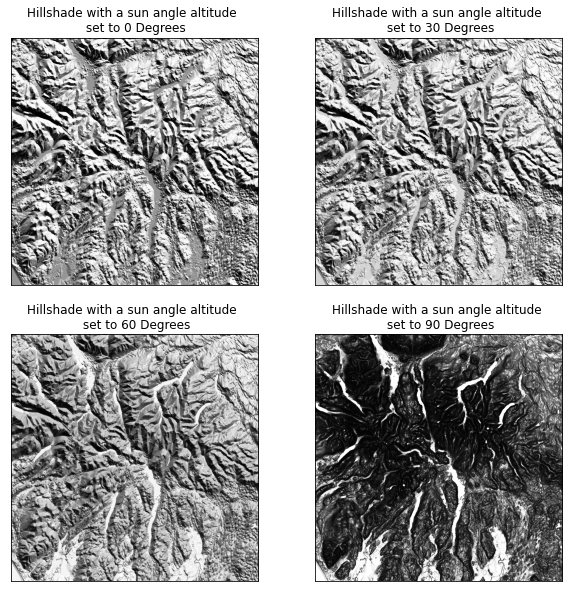

In [9]:
# Set figure size and axes
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

# Create hillshade maps with inclination angles of 0°, 90°, 180° and 270°
altitude = [0, 30, 60, 90]
axes =[ax, ax2, ax3, ax4]
for i in range(0,4):
    # Change the azimuth of the hillshade layer
    hillshade_altitude = es.hillshade(elevation, altitude=altitude[i])
    # Plot the hillshade layer with the modified azimuth
    ep.plot_bands(hillshade_altitude, ax=axes[i], 
                  cbar=False, title="Hillshade with a sun angle altitude \n set to " + str(altitude[i])+ " Degrees")

# Save the figure - uncomment code below
#fig.savefig("LDalitudehillshades")

<a id='hill'></a>
## Using Earthpy with hillshade
The terrain and hillshade maps can be combined in one plot to create an image that looks 3-dimesional. 

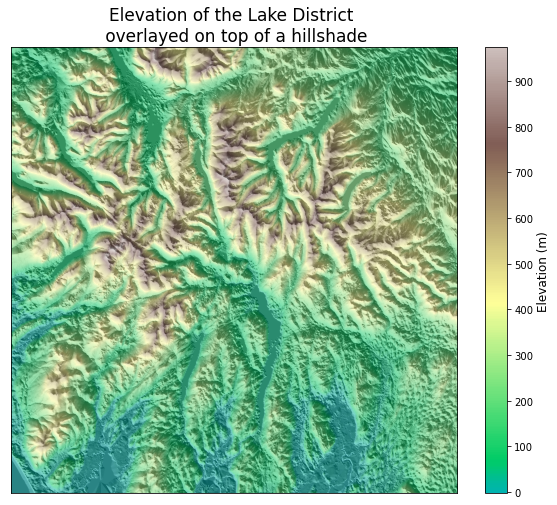

In [10]:
# Set figure size and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Create terrainmap
ep.plot_bands( elevation, cbar=False,
    ax=ax, cmap=new_cmap)

# Create hillshade
hillshade = es.hillshade(elevation)
ax.imshow(hillshade, cmap="Greys", alpha=0.5)

# Add colorbar and customize the map
plt.colorbar(sm, ax=ax, ticks=np.arange(-100, 1000, 100), shrink=0.82).set_label(label = 'Elevation (m)', size=12)
ax.set_title("Elevation of the Lake District \n overlayed on top of a hillshade", size=17)

plt.show()

# Save the figure - uncomment code below
#fig.savefig("LDhillshade")

<a id='References'></a>
# References 

[1] OS Terrain 50 [ASC geospatial data], Scale 1:50000, Tiles: NY10, NY11, NY12, NY20, NY21, NY22, NY30, NY31, NY32, NY40, NY41, NY42, NY50, NY51, NY52, SD18, SD19, SD28, SD29, SD38, SD39, SD48, SD49, SD58, SD59, Updated: 29 May 2019, Ordnance Survey (GB), Using: EDINA Digimap Ordnance Survey Service, <https://digimap.edina.ac.uk>, Downloaded: 2020-06-11 09:06:43.042
